In [55]:
# Required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import boto3
from dotenv import load_dotenv
from scipy import stats
import warnings
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    auc,
    fbeta_score,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import re
from typing import List, Dict



random_state = 55

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## Get Dataset

In [2]:
FILE_NAME = "feature_frame.csv"
S3_DIR = "groceries/box_builder_dataset/"
BUCKET_NAME = "zrive-ds-data"
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = "../../data/"
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME


def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return

    try:
        s3 = boto3.client(
            "s3",
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )

        key = S3_DIR + FILE_NAME

        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")

    except Exception as e:
        print(f"Error downloading file: {e}")
        raise


# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)

File already exists at ../../data/feature_frame.csv


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df["outcome"].value_counts(normalize=True)

outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64

It's a very unbalanced dataset.

- Label 1 -> 1.15%
- Label 0 -> 98.85%

## Filtering Data

We should only be focusing on purchases of at least 5 items, since it is a requirement coming from the sales team.

In [5]:
items_bought_per_order = (
    df[df["outcome"] == 1].groupby("order_id").size().reset_index(name="items_bought")
)
# row num diference between df and items_bought_per_order
df_with_count = df.merge(items_bought_per_order, on="order_id", how="left")
df_with_count["items_bought"].fillna(0, inplace=True)

sales_df = df_with_count[df_with_count["items_bought"] > 4]
print(
    f"Deleted items with less than 5 items bought: {len(df_with_count) - len(sales_df)}  ({(len(df_with_count) - len(sales_df))*100/len(df_with_count):.2f}%)"
)

Deleted items with less than 5 items bought: 716596  (24.88%)


## Data Split

I'll split the data in three subsets:
1. Train Data -> ~70%
2. Validation data -> ~20%
3. Test data -> ~10%

The key in most supervised learning is how we split the data. 
In this case: 
1. Mantain temporality, because the bussines may grow or evolve along the time, instead could be data leakage
2. I will not divide products in same order in different data splits, in order to avoid data leakage
3. I will make stratified sampling in order to preserve the target distribution

In [36]:
def temporal_split_data(
    df: pd.DataFrame,
    target_col: str = 'outcome',
    train_size: float = 0.7,
    val_size: float = 0.2,
    order_id_col: str = 'order_id',
    date_col: str = 'created_at'
) -> tuple:
    """
    Split temporal de datos preservando grupos de order_id y distribución temporal.
    """
    
    # Asegurar que la columna de fecha esté en formato datetime
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    
    # Obtener el primer pedido de cada order_id
    order_dates = df_copy.groupby(order_id_col)[date_col].min().reset_index()
    order_dates = order_dates.sort_values(date_col)
    
    # Calcular los thresholds temporales
    total_orders = len(order_dates)
    train_orders = int(total_orders * train_size)
    val_orders = int(total_orders * val_size)
    
    # Crear sets de order_ids para cada split
    train_orders_set = set(order_dates.iloc[:train_orders][order_id_col])
    val_orders_set = set(order_dates.iloc[train_orders:train_orders + val_orders][order_id_col])
    test_orders_set = set(order_dates.iloc[train_orders + val_orders:][order_id_col])
    
    # Crear máscaras
    train_mask = df_copy[order_id_col].isin(train_orders_set)
    val_mask = df_copy[order_id_col].isin(val_orders_set)
    test_mask = df_copy[order_id_col].isin(test_orders_set)
    
    # Separar features y target
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]
    
    # Aplicar split
    X_train = X[train_mask].copy()
    X_val = X[val_mask].copy()
    X_test = X[test_mask].copy()
    
    y_train = y[train_mask].copy()
    y_val = y[val_mask].copy()
    y_test = y[test_mask].copy()
    
    # Estadísticas
    train_cutoff_date = order_dates.iloc[train_orders - 1][date_col]
    val_cutoff_date = order_dates.iloc[train_orders + val_orders - 1][date_col]
    
    print(f"Split temporal completado:")
    print(f"  Train ({len(X_train)/len(df)*100:.2f}%): {len(X_train):,} filas ({len(train_orders_set):,} órdenes)")
    print(f"  Val   ({len(X_val)/len(df)*100:.2f}%): {len(X_val):,} filas ({len(val_orders_set):,} órdenes)")
    print(f"  Test  ({len(X_test)/len(df)*100:.2f}%): {len(X_test):,} filas ({len(test_orders_set):,} órdenes)")
    
    print(f"\nFechas de corte:")
    print(f"  Train cutoff: {train_cutoff_date}")
    print(f"  Val cutoff:   {val_cutoff_date}")
    
    print(f"\nDistribución del target:")
    print(f"  Train: {y_train.value_counts(normalize=True).to_dict()}")
    print(f"  Val:   {y_val.value_counts(normalize=True).to_dict()}")
    print(f"  Test:  {y_test.value_counts(normalize=True).to_dict()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_data(
    df=df,
    target_col='outcome'
)

Split temporal completado:
  Train (66.93%): 1,927,962 filas (2,412 órdenes)
  Val   (21.55%): 620,646 filas (689 órdenes)
  Test  (11.52%): 331,941 filas (345 órdenes)

Fechas de corte:
  Train cutoff: 2021-02-08 13:41:15
  Val cutoff:   2021-02-24 09:53:18

Distribución del target:
  Train: {0.0: 0.9877139694662032, 1.0: 0.012286030533796828}
  Val:   {0.0: 0.9897526126004196, 1.0: 0.010247387399580437}
  Test:  {0.0: 0.9904049213565062, 1.0: 0.009595078643493874}


## Baseline

To compare and justify our ML Models, we should always beat a baseline.

In this case, the `global_popularity` feature will be a good baseline to decide if the user will purchase or not

In [8]:
class PopularityBaseline:
        def __init__(self, threshold, popularity_col):
            self.threshold = threshold
            self.popularity_col = popularity_col
        
        def predict(self, X):
            return (X[self.popularity_col] >= self.threshold).astype(int)
        
        def predict_proba(self, X):
            proba_pos = X[self.popularity_col] / X[self.popularity_col].max()
            proba_neg = 1 - proba_pos
            return np.column_stack([proba_neg, proba_pos])
    
PopularityBaseline = PopularityBaseline(0.05, 'global_popularity')

## Evaluate Model

I'll use Fbeta score (with beta 0.3) givin more importance to precision over recall

In [9]:
def fbeta_03_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.3)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    f03_score = fbeta_03_score(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    return {
        'name': model_name,
        'f03_score': f03_score,
        'y_proba': y_proba,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    }

def plot_curves_comparison(results_list, title_suffix="", figsize=(15, 6)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    
    for result in results_list:
        ax1.plot(result['fpr'], result['tpr'], 
                label=f"{result['name']} (F0.3={result['f03_score']:.3f})",
                linewidth=2)
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curves {title_suffix}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    baseline_precision = results_list[0]['precision'].mean() if results_list else 0.5
    ax2.axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, label='Baseline')
    
    for result in results_list:
        ax2.plot(result['recall'], result['precision'], 
                label=f"{result['name']} (F0.3={result['f03_score']:.3f})", 
                linewidth=2)
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curves {title_suffix}')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## Building linear model

We have the dataset ready for sales team, now, we have to develop a machine learning model that, given a user and a product, predicts if the user would purchase. 

In [10]:
sales_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'items_bought'],
      dtype='object')

So, we have to build a model to predict the 'outcome' feature given the other features:

- User info ->    ```user_order_seq```, ```count_adults```, ```count_children```, ```count_babies```, ```count_pets```, ```people_ex_baby```
- Product info -> ```product_type```, ```normalised_price```, ```discount_pct```, ```vendor```, ```global_popularity```
- Product-User info -> ```ordered_before```, ```abandoned_before```, ```active_snoozed```, ```set_as_regular``` and those related with days since...
- Target -> ```outcome```

What happens with other variables? 

- IDs -> Don`t give numeric information, delete it (```order_id``` will be important to split data, but then, delete it)
- Items_bought -> We won´t have that info in production


We still have 2 variables left: 
1. ```created_at```: In production will be the current date. I will preprocess it and get day num, month num and week num.
2. ```order_date```: Redundant, delete it. 


In [11]:
target = "outcome"
cols_to_drop = ["variant_id", "user_id", "order_date", "items_bought"]
order_id_col = "order_id"

feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]
feature_cols

Index(['product_type', 'order_id', 'created_at', 'user_order_seq',
       'ordered_before', 'abandoned_before', 'active_snoozed',
       'set_as_regular', 'normalised_price', 'discount_pct', 'vendor',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

Now, we are going to try with differents models, iteratively, so first models only will have binary and numeric columns

In [12]:
numeric_cols = sales_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('order_id')
categorical_cols = sales_df[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

In [13]:
def create_logistic_pipelines():
    
    pipelines = {}
    
    pipelines['No Penalty'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(penalty=None, max_iter=1000, random_state=random_state))
    ])
    
    C_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    
    for C in C_values:
        pipelines[f'L1 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                       max_iter=1000, random_state=random_state))
        ])
    
    for C in C_values:
        pipelines[f'L2 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l2', C=C, max_iter=1000, 
                                       random_state=random_state))
        ])
    
    return pipelines

We are goint to compare how regularization performs in this dataset, comparing ridge and lasso

   Training No Penalty...
   Training L1 (C=1e-06)...
   Training L1 (C=1e-05)...
   Training L1 (C=0.0001)...
   Training L1 (C=0.001)...
   Training L1 (C=0.01)...
   Training L1 (C=0.1)...
   Training L1 (C=1)...
   Training L1 (C=10)...
   Training L1 (C=100)...
   Training L2 (C=1e-06)...
   Training L2 (C=1e-05)...
   Training L2 (C=0.0001)...
   Training L2 (C=0.001)...
   Training L2 (C=0.01)...
   Training L2 (C=0.1)...
   Training L2 (C=1)...
   Training L2 (C=10)...
   Training L2 (C=100)...
   ✅ All models trained


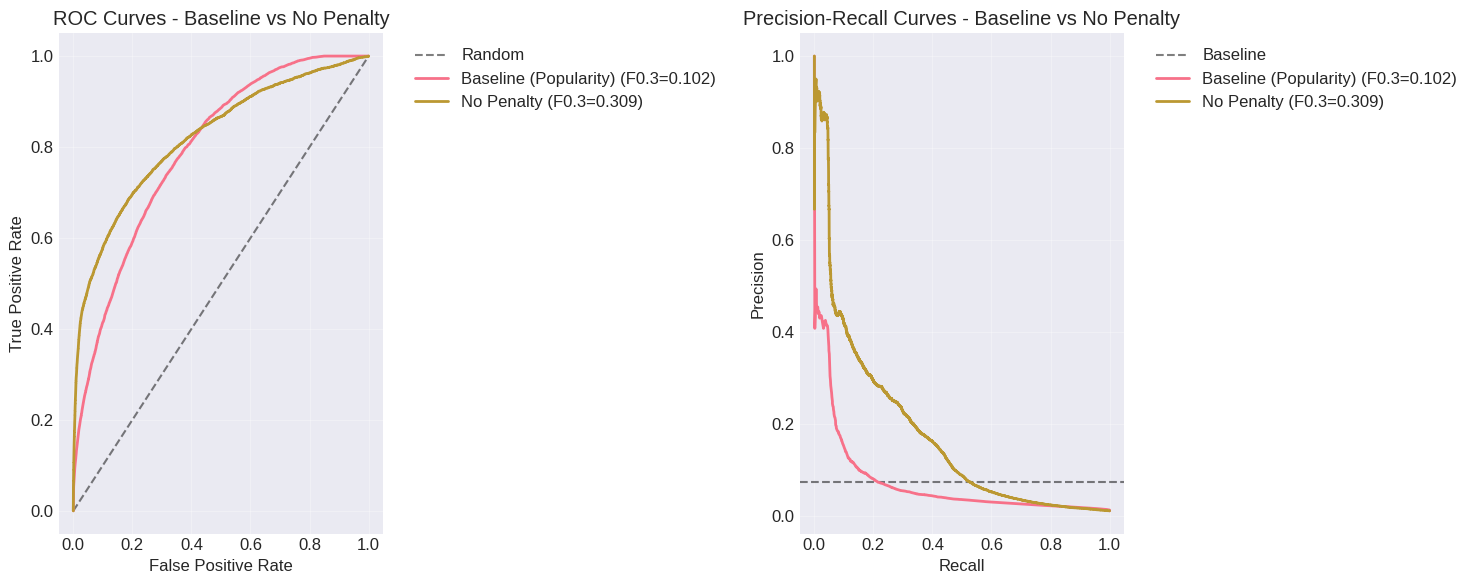

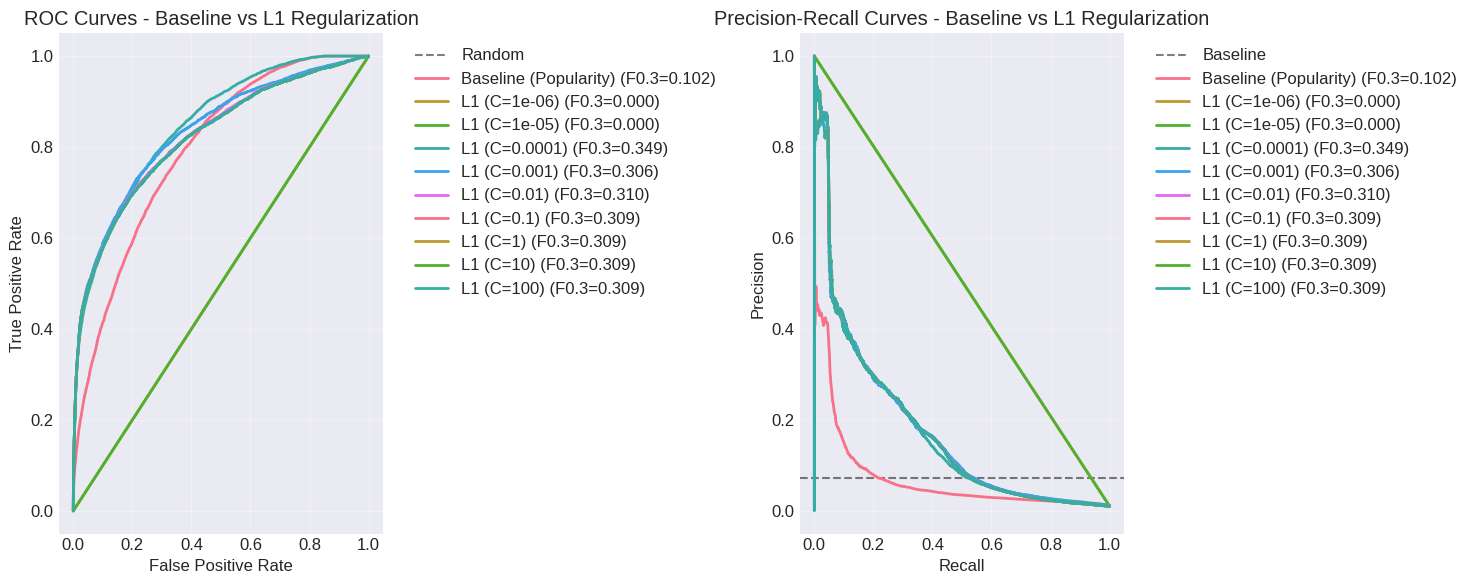

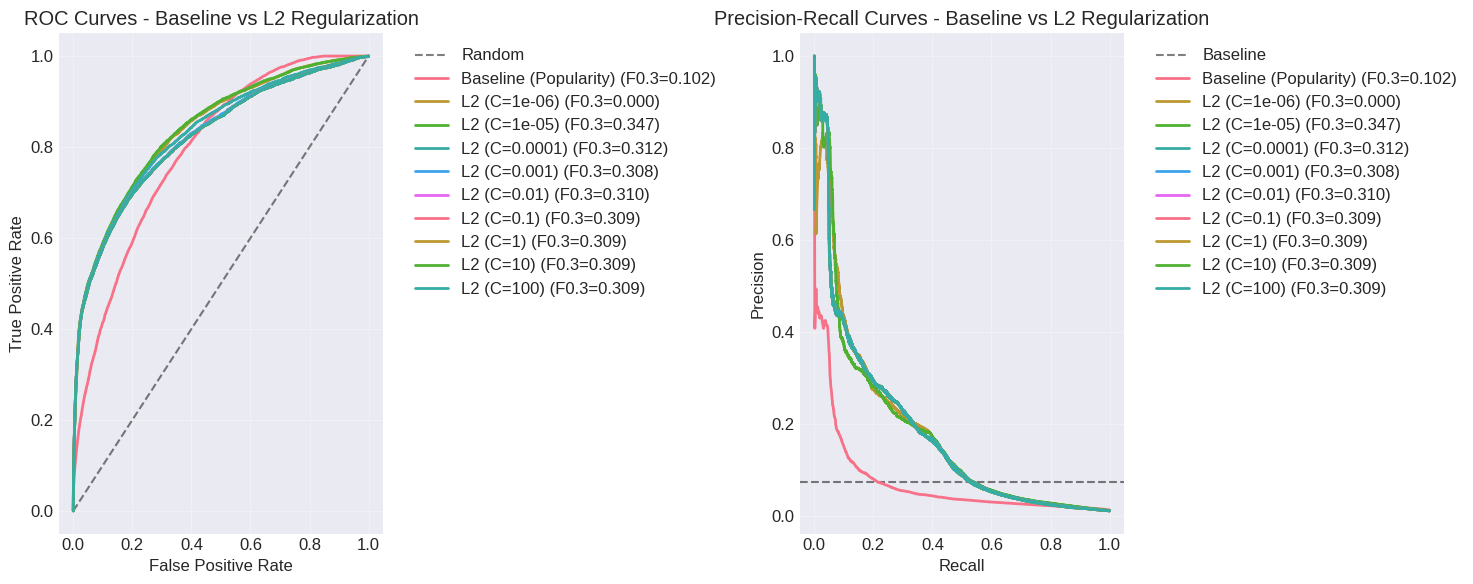

In [14]:

X_train_num = X_train[numeric_cols].copy()
X_val_num = X_val[numeric_cols].copy() 
X_test_num = X_test[numeric_cols].copy()

pipelines = create_logistic_pipelines()

trained_models = {}
for name, pipeline in pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_num, y_train)
    trained_models[name] = pipeline

print("   ✅ All models trained")

all_results = []
baseline_result = evaluate_model(PopularityBaseline, X_val_num, y_val, "Baseline (Popularity)")
all_results.append(baseline_result)

for name, model in trained_models.items():
    result = evaluate_model(model, X_val_num, y_val, name)
    all_results.append(result)

baseline_results = [r for r in all_results if 'Baseline' in r['name'] or 'No Penalty' in r['name']]
l1_results = [r for r in all_results if 'Baseline' in r['name'] or 'L1' in r['name']]
l2_results = [r for r in all_results if 'Baseline' in r['name'] or 'L2' in r['name']]

fig1 = plot_curves_comparison(baseline_results, "- Baseline vs No Penalty")
plt.show()

fig2 = plot_curves_comparison(l1_results, "- Baseline vs L1 Regularization")
plt.show()

fig3 = plot_curves_comparison(l2_results, "- Baseline vs L2 Regularization")
plt.show()

The baseline is beated by far. Regularization improves the performance but there isn't so much diference. These are slighly best models:
1. `L1 (C=0.0001)`
2. `L2 (C=1e-05)`

Let's see how regularization is affecting the parameters

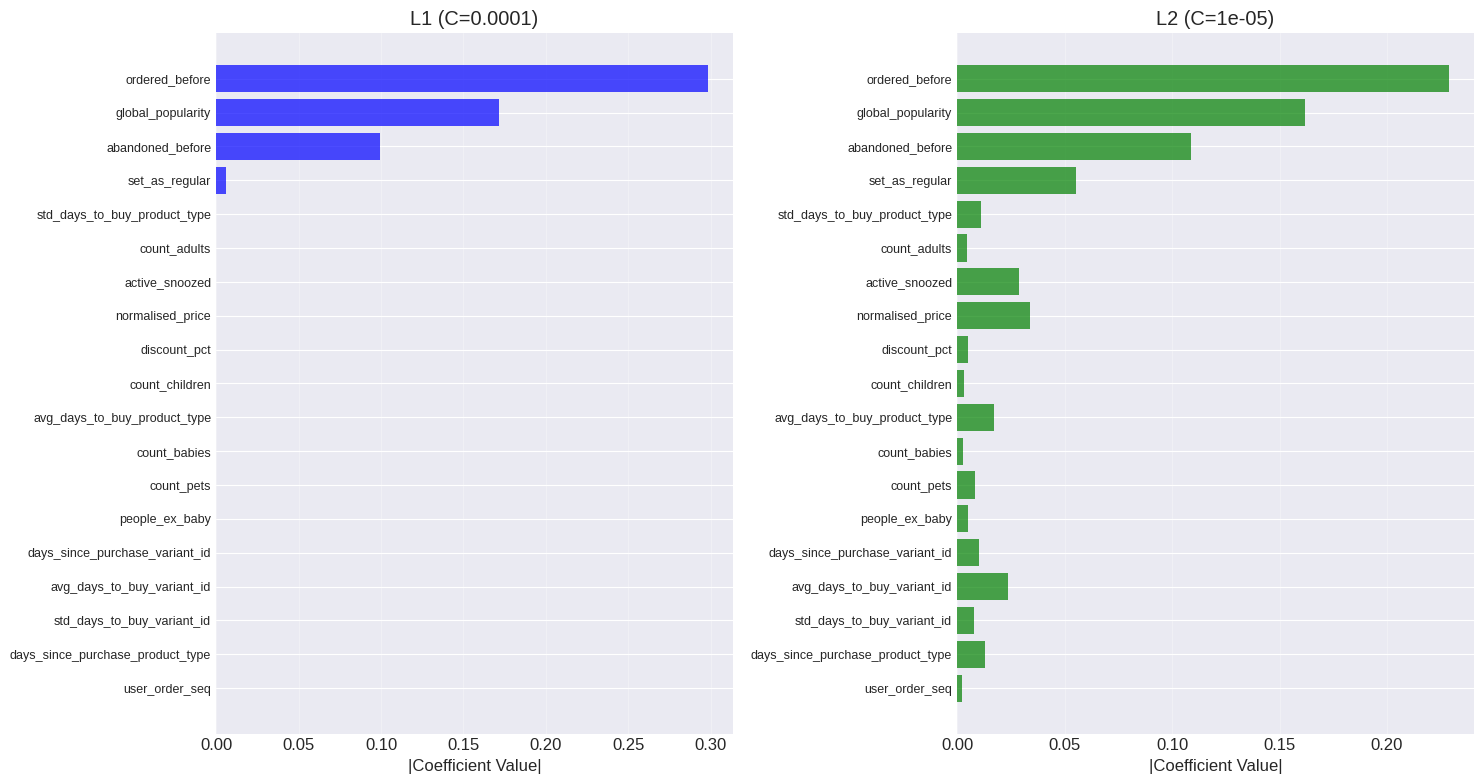

In [19]:
def plot_model_weights(
    l1_model_name: str, l2_model_name: str, numeric_cols, figsize=(15, 8)
):
    
    l1_model = trained_models[l1_model_name]
    l2_model = trained_models[l2_model_name]
    
    l1_coefs = l1_model.named_steps['model'].coef_[0]
    l2_coefs = l2_model.named_steps['model'].coef_[0]
    
    weights_df = pd.DataFrame({
        'Feature': numeric_cols,
        'L1_Weight': np.abs(l1_coefs),  
        'L2_Weight': np.abs(l2_coefs)
    })
    
    weights_df = weights_df.sort_values('L1_Weight', ascending=True) 
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.barh(range(len(weights_df)), weights_df['L1_Weight'], color='blue', alpha=0.7)
    ax1.set_yticks(range(len(weights_df)))
    ax1.set_yticklabels(weights_df['Feature'], fontsize=9)
    ax1.set_xlabel('|Coefficient Value|')
    ax1.set_title(f'{l1_model_name}')
    ax1.grid(True, alpha=0.3, axis='x')
    
    ax2.barh(range(len(weights_df)), weights_df['L2_Weight'], color='green', alpha=0.7)
    ax2.set_yticks(range(len(weights_df)))
    ax2.set_yticklabels(weights_df['Feature'], fontsize=9)
    ax2.set_xlabel('|Coefficient Value|')
    ax2.set_title(f'{l2_model_name}')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

plot_model_weights('L1 (C=0.0001)', 'L2 (C=1e-05)', numeric_cols)

We can se that features `ordered_before`, `global_popularity`, `abandoned_before` and `set_as_regular` are the most importants. So we are going to remove the other ones

In [38]:
predictive_cols = [
    'ordered_before',
    'global_popularity',
    'abandoned_before',
    'set_as_regular'
]

### Add `created_at` feature

Now, i'll try adding the categorical `created_at` feature, but first i'll preproces it:

```created_at``` feature has this type: **'2020-02-05 16:46:19'**

That isn´t a numeric value, so I will create 6 features from that date:
1. ```year``` (2020)
2. ```month_num``` (02)
3. ```dom``` day of the month (05)
4. ```doy``` day of the year (36)
5. ```woy``` week of the year (05)
5. ```is_weekend``` 0 or 1

In [80]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, date_column="created_at"):
        self.date_column = date_column
        self.date_feature_names = [
            'year', 'month_num', 'dom', 'doy', 'woy', 'dow_num', 'is_weekend'
        ]

    def process_date(self, input_str: str) -> dict:
        date_str = input_str.split(" ")[0]

        regex = re.compile(r"\d{4}-\d{2}-\d{2}")
        if not re.match(regex, date_str):
            return {name: 0 for name in self.date_feature_names}

        my_date = datetime.strptime(date_str, "%Y-%m-%d").date()
        date_feats = {}

        date_feats["year"] = int(my_date.strftime("%Y"))
        date_feats["month_num"] = int(my_date.strftime("%m"))
        date_feats["dom"] = int(my_date.strftime("%d"))
        date_feats["doy"] = int(my_date.strftime("%j"))
        date_feats["woy"] = int(my_date.strftime("%W"))

        # Fixing day of week to start on Mon (1), end on Sun (7)
        dow = my_date.strftime("%w")
        if dow == "0":
            dow = 7
        date_feats["dow_num"] = int(dow)

        date_feats["is_weekend"] = 1 if int(dow) > 5 else 0

        return date_feats

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()

        date_features = []
        for date_value in X_copy[self.date_column]:
            date_features.append(self.process_date(str(date_value)))

        date_df = pd.DataFrame(date_features, index=X_copy.index)

        X_transformed = pd.concat([X_copy, date_df], axis=1)
        X_transformed = X_transformed.drop(columns=[self.date_column])

        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        output_features = [f for f in input_features if f != self.date_column]
        output_features.extend(self.date_feature_names)
        
        return np.array(output_features)

### Categorical Encoders

Also, I'll try with Frecuency encoders and Target Encoder on `vendor` and `product_type` features

In [82]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        for column in self.categorical_columns:
            if column in X.columns:
                frequencies = X[column].value_counts(normalize=True).to_dict()
                self.frequency_maps[column] = frequencies
        return self

    def transform(self, X):
        X_copy = X.copy()

        for column in self.categorical_columns:
            if column in X_copy.columns:
                default_value = (
                    min(self.frequency_maps[column].values())
                    if self.frequency_maps[column]
                    else 0
                )
                X_copy[column] = X_copy[column].map(
                    lambda x: self.frequency_maps[column].get(x, default_value)
                )

        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        return np.array(input_features)


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        categorical_columns,
        target_column="outcome",
        min_samples_leaf=1,
        smoothing=1.0,
    ):
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.target_means = {}
        self.global_mean = 0

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()

        self.global_mean = y.mean()

        if len(X) != len(y):
            raise ValueError("X and y must have the same number of rows")

        for column in self.categorical_columns:
            if column in X.columns:
                temp_df = pd.DataFrame({
                    'category': X[column],
                    'target': y
                })
                agg_df = temp_df.groupby('category').agg({
                    'target': ['count', 'mean']
                })
                agg_df.columns = ['count', 'mean']
                agg_df['smooth_mean'] = (
                    (agg_df['count'] * agg_df['mean'] + self.smoothing * self.global_mean) /
                    (agg_df['count'] + self.smoothing)
                )

                self.target_means[column] = agg_df['smooth_mean'].to_dict()

        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].map(
                    lambda x: self.target_means[column].get(x, self.global_mean)
                )
        
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        return np.array(input_features)

In [83]:
def create_mixed_pipeline(encoder_type='frequency', penalty='l1', C=0.0001):
    
    if encoder_type == 'frequency':
        categorical_transformer = FrequencyEncoder(categorical_cols)
    elif encoder_type == 'target':
        categorical_transformer = TargetEncoder(categorical_cols)
    else:
        raise ValueError("encoder_type must be 'frequency' or 'target'")
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), predictive_cols), 
            ('cat', categorical_transformer, categorical_cols), 
            ('date', DateFeatureTransformer(), ['created_at']) 
        ],
        remainder='drop' 
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            penalty=penalty, C=C, solver='liblinear', 
            max_iter=1000, random_state=random_state
        ))
    ])
    
    return pipeline

categorical_pipelines = {
    'Frequency Encoder': create_mixed_pipeline('frequency', 'l1', 0.0001),
    'Target Encoder': create_mixed_pipeline('target', 'l1', 0.0001)
}

X_train_cat = X_train[predictive_cols + categorical_cols].copy()
X_val_cat = X_val[predictive_cols + categorical_cols].copy()
X_test_cat = X_test[predictive_cols + categorical_cols].copy()

trained_categorical_models = {}
for name, pipeline in categorical_pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_cat, y_train)
    trained_categorical_models[name] = pipeline


   Training Frequency Encoder...
   Training Target Encoder...


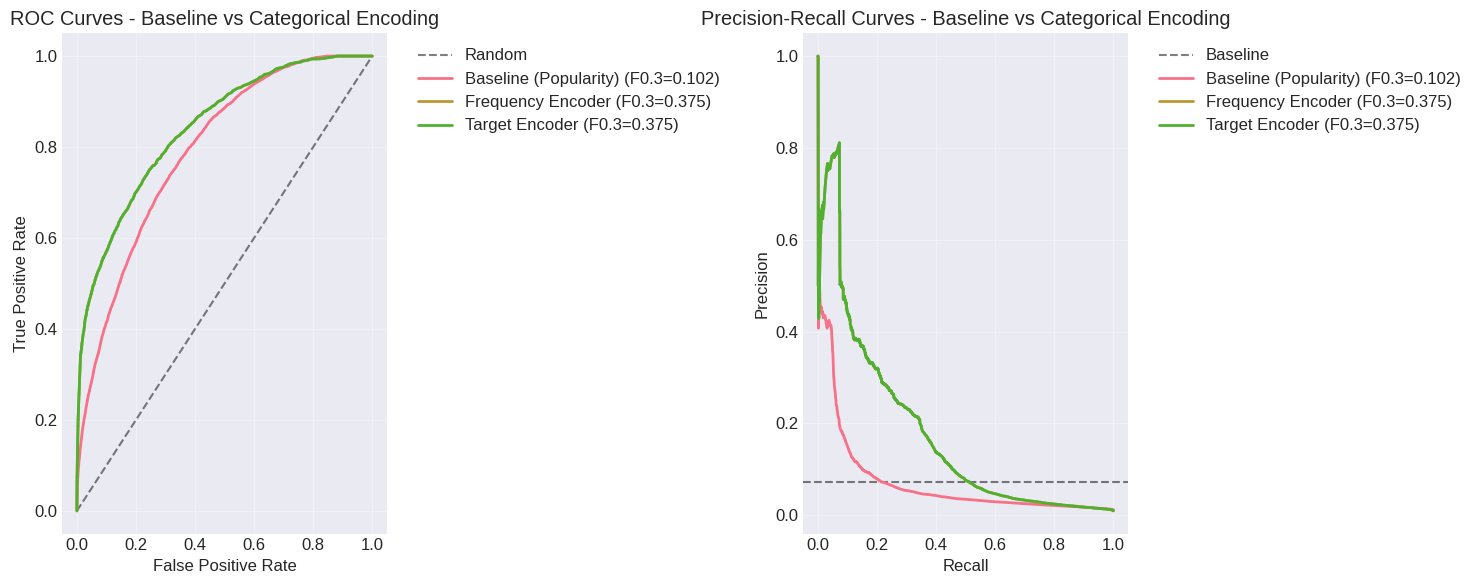

In [84]:
categorical_results = []

baseline_result = [r for r in all_results if 'Baseline' in r['name']][0]
categorical_results.append(baseline_result)

for name, model in trained_categorical_models.items():
    result = evaluate_model(model, X_test_cat, y_test, name)
    categorical_results.append(result)

fig1 = plot_curves_comparison(
    categorical_results, 
    "- Baseline vs Categorical Encoding"
)
plt.show()

They have improved the f0.3 score a little bit. lets see parameters weights

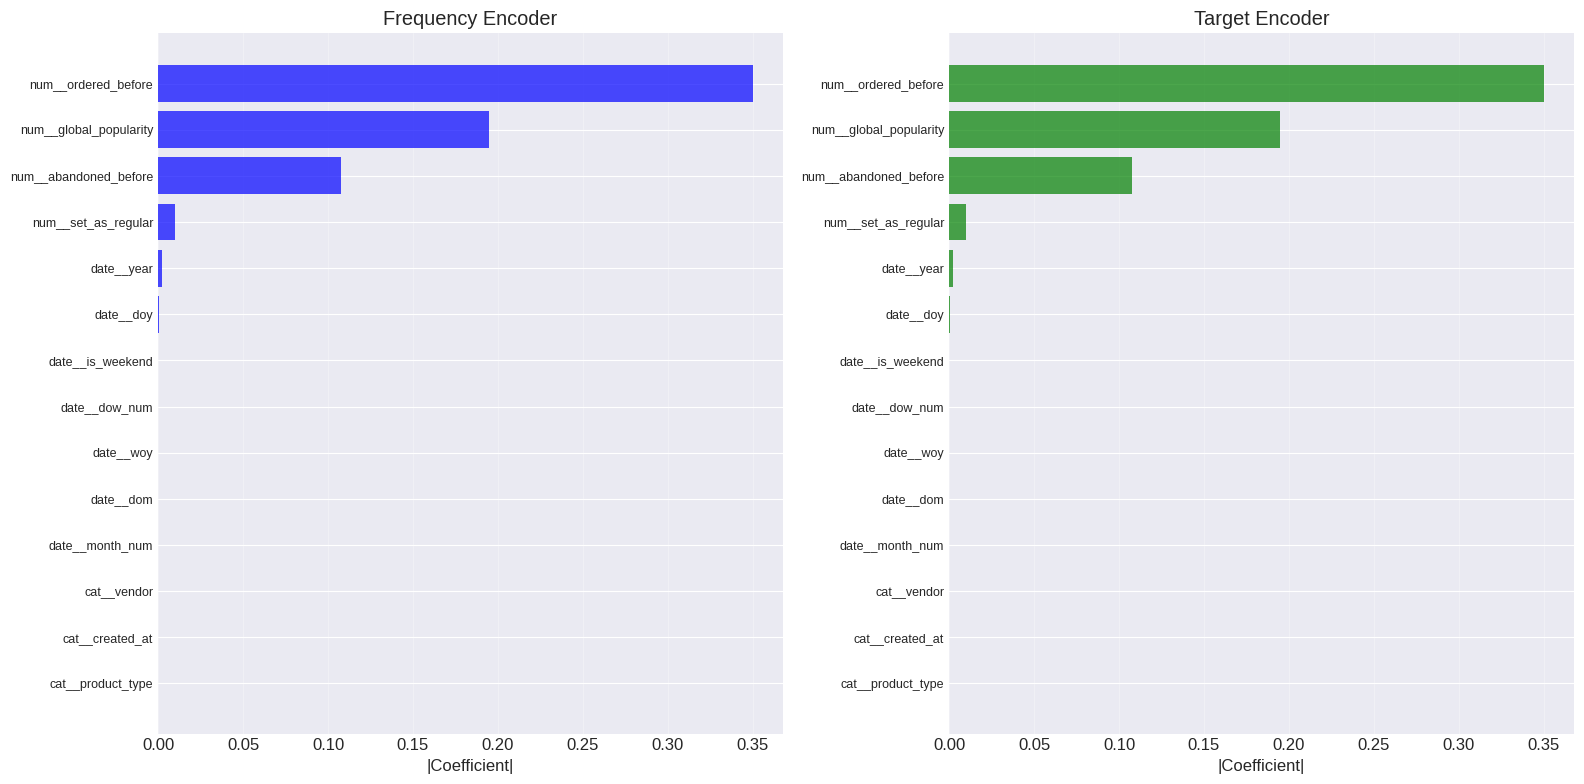

In [89]:
def plot_two_pipelines(model1_name='Frequency Encoder', model2_name='Target Encoder', figsize=(16, 8)):
    
    model1 = trained_categorical_models[model1_name]
    model2 = trained_categorical_models[model2_name]
    
    coefs1 = model1.named_steps['model'].coef_[0]
    coefs2 = model2.named_steps['model'].coef_[0]
    
    names1 = model1.named_steps['preprocessor'].get_feature_names_out()
    names2 = model2.named_steps['preprocessor'].get_feature_names_out()
    
    df1 = pd.DataFrame({
        'Feature': names1,
        'Weight': np.abs(coefs1)
    }).sort_values('Weight', ascending=True)
    
    df2 = pd.DataFrame({
        'Feature': names2,
        'Weight': np.abs(coefs2)
    }).sort_values('Weight', ascending=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.barh(range(len(df1)), df1['Weight'], color='blue', alpha=0.7)
    ax1.set_yticks(range(len(df1)))
    ax1.set_yticklabels(df1['Feature'], fontsize=9)
    ax1.set_xlabel('|Coefficient|')
    ax1.set_title(f'{model1_name}')
    ax1.grid(True, alpha=0.3, axis='x')
    
    ax2.barh(range(len(df2)), df2['Weight'], color='green', alpha=0.7)
    ax2.set_yticks(range(len(df2)))
    ax2.set_yticklabels(df2['Feature'], fontsize=9)
    ax2.set_xlabel('|Coefficient|')
    ax2.set_title(f'{model2_name}')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return df1, df2

df_freq, df_target = plot_two_pipelines('Frequency Encoder', 'Target Encoder')

We can see that date_year and date_doy have little importance. 